# Restarting simulations
In this tutorial, we are going to restart a simulation from the last time-step of a previous model. This is useful, for instance, when we want to run time-consuming simulations and we have limited walltime. Another application is when we want to change one parameter at some point of the model run.    

To use this tutorial, we first have to run the simulation of the single asperity (3D). This will be our initial simulation. Subsequently, we use the current notebook to generate the input file to restart the model.   

In the single asperity simulation (3D) tutorial, we simulate slip on a 2D fault (within a 3D medium) with a single velocity-weakening asperity, embedded in a velocity-strengthening (creeping) matrix. We begin by importing some modules.

In [8]:
# Make plots interactive in the notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

# Add QDYN source directory to PATH
# Go up in the directory tree
upup = [os.pardir]*2
qdyn_dir = os.path.join(*upup)

src_dir = os.path.abspath(
    os.path.join(
        os.path.join(os.path.abspath(""), qdyn_dir), "qdyn")
)

if src_dir not in sys.path:
    sys.path.append(src_dir)

# Import QDYN wrapper 
from pyqdyn import qdyn

To prepare a simulation, the global simulation and mesh parameters will have to be specified. This is done in three steps:

1. Specify global parameters, like simulation duration, output resolution, mesh size, and default mesh values
2. Render the mesh (assigning default values to every element)
3. Override the default mesh parameter values to create heterogeneity in the simulation


In this simulation, the only heterogeneity stems from a lateral variation in the direct effect parameter $a$, which is chosen such that the asperity has $(a-b)<0$, and such that the matrix has $(a-b)>0$.

Recall that unlike the initial simulation, we also override the settings related to restarting the model. The restart time and slip are directly retrieved from the output `output_ox_last` with the python function `restart_time()` and `restart_slip()`. 

**Important**: The simulation time `set_dict["TMAX"]` set in the input file has to be larger than the starting time `set_dict["RESTART_TIME"]`. Otherwise, the simulation won't run

In [9]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # Seconds per year
L = 5e3                     # Length of fault along-strike
W = 5e3                     # Length of fault along-dip
resolution = 5              # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["FEAT_RESTART"] = 1                        # Restart simulation from existing output
set_dict["RESTART_TIME"] = p.restart_time()         # Time of last snapshot in previous simulation
set_dict["RESTART_SLIP"] = p.restart_slip()         # Slip of last snapshot in previous simulation

set_dict["MESHDIM"] = 2        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FAULT_TYPE"] = 2     # Thrust fault
set_dict["TMAX"] = 10*t_yr      # Maximum simulation time [s] (NOTE: > restart time)
set_dict["NTOUT"] = 100        # Save output every N steps
set_dict["NXOUT"] = 2          # Snapshot resolution along-strike (every N elements)
set_dict["NWOUT"] = 2          # Snapshot resolution along-dip (every N elements)
set_dict["V_PL"] = 1e-9        # Plate velocity
set_dict["MU"] = 3e10          # Shear modulus
set_dict["SIGMA"] = 1e7        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)
set_dict["Z_CORNER"] = -1e4    # Base of the fault (depth taken <0); NOTE: Z_CORNER must be < -W !
set_dict["DIP_W"] = 30         # Dip of the fault

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 0.2e-2    # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = 1e-2      # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 1e-3     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["V_0"] = set_dict["V_PL"]     # Initial velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = 0.99 * set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial (steady-)state [s]

# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])
# Nucleation length [m]
Lc = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / ((set_dict["SET_DICT_RSF"]["B"] - set_dict["SET_DICT_RSF"]["A"]) * set_dict["SIGMA"])

print(f"Process zone size: {Lb} m \t Nucleation length: {Lc} m")

# Find next power of two for number of mesh elements
Nx = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
Nw = int(np.power(2, np.ceil(np.log2(resolution * W / Lb))))

# Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, Nx, dtype=float)
z = np.linspace(-W/2, W/2, Nw, dtype=float)
X, Z = np.meshgrid(x, z)
z = -(set_dict["Z_CORNER"] + (z + W/2) * np.cos(set_dict["DIP_W"] * np.pi / 180.))

# Set mesh size and fault length
set_dict["NX"] = Nx
set_dict["NW"] = Nw
set_dict["L"] = L
set_dict["W"] = W 
set_dict["DW"] = W / Nw
# Set time series output node to the middle of the fault
set_dict["IC"] = Nx * (Nw // 2) + Nx // 2

""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
scale = 1e3
p.mesh_dict["A"] = 2 * set_dict["SET_DICT_RSF"]["B"] * (1 - 0.9*np.exp(- (X**2 + Z**2) / (2 * scale**2))).ravel()

print("Number of mesh elements: " + str(set_dict["N"]))

Process zone size: 300.0 m 	 Nucleation length: 375.0 m
Number of mesh elements: 16384


We override the values of `sigma`, `theta` and `v` using the information from the last snapshot

In [10]:
# Read output from initial simulation
p.read_output(read_ox_last=True)

# Override values of sigma, theta and initial velocity based on last timestep of previous simulation
sigma_new = p.ox_last["sigma"]
theta_new = p.ox_last["theta"]
v0_new = p.ox_last["v"]

p.mesh_dict["SIGMA"] = sigma_new
p.mesh_dict["TH_0"] = theta_new
p.mesh_dict["V_0"] = v0_new

""" WRITE INPUT """

# Write input to qdyn.in
p.write_input()

True

To see the effect of setting a heterogeneous value of a over the mesh, we can plot  versus position on the fault:

<IPython.core.display.Javascript object>


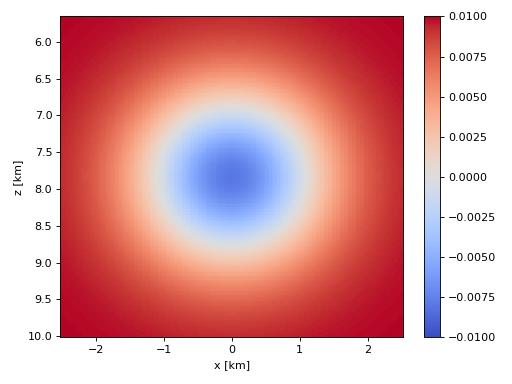

In [12]:
plt.figure()
plt.pcolormesh(x * 1e-3, z * 1e-3, (p.mesh_dict["A"] - p.mesh_dict["B"]).reshape(X.shape), 
               vmin=-0.01, vmax=0.01, cmap="coolwarm")
plt.colorbar()
plt.xlabel("x [km]")
plt.ylabel("z [km]")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

As desired, the asperity is defined by $(a-b)<0$, embedded in a stable matrix with $(a-b)>0$.

Run the simulation

In [14]:
p.run()

 Number of processors =            1
 Start reading input...
    Mesh input complete
   Flags input complete
 Input complete
 Initializing mesh...
 2D fault, uniform grid along-strike
 Impedance =       0.500E+07                                                    
                                                                                
                                                                                
                   
 Intializing kernel: ...
 Generating 3D kernel...
 OouraFFT applied along-strike
 sigma_coupling=0
 Kernel intialized
 Values at selected point of the fault:
 
     it,  dt (secs), time (yrs), v_max (m/s), sigma_max (MPa)
 Initialising RK45 solver
 Finished initialising RK45 solver
 Initialization completed
      0   0.000E+00   0.500E+01   0.269E-07   0.100E+02
    100   0.389E+04   0.501E+01   0.166E-07   0.100E+02
    200   0.198E+06   0.522E+01   0.100E-08   0.100E+02
    300   0.397E+04   0.533E+01   0.408E-08   0.100E+02
    400   0.103E+03 

0

After running the simulation, we can check the last snapshot. In this case we read the output with the flag `read_ox_last` set to `True`

In [ ]:
# Read output
p.read_output(read_ox_last=True)

In [ ]:
# Plot last snapshot from lastox file


x = p.ox_last["x"].values.reshape((p.set_dict["NW"], p.set_dict["NX"]))
y = p.ox_last["y"].values.reshape((p.set_dict["NW"], p.set_dict["NX"]))
z = p.ox_last["z"].values.reshape((p.set_dict["NW"], p.set_dict["NX"]))
v = np.log10(p.ox_last["v"].values.reshape((p.set_dict["NW"], p.set_dict["NX"])))

norm = cm.colors.Normalize(vmin=-10, vmax=-8)
cmap = cm.magma

plt.close("all")
fig, ax = plt.subplots(figsize=(9, 5), constrained_layout=True, subplot_kw={"projection": "3d"})
CS = ax.plot_surface(x, y, z, facecolors=cmap(norm(v)), linewidth=0, antialiased=False, shade=False)
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label = " Log velocity")
#ax.set_title("t = " + str(t_ox_step_value) + ' yr')
fig.show()

We can check if the last snapshot from the file `lastox` is consistent with the last snapshot from the file `ox`

In [ ]:
# Plot last snapshot from ox file
inds = (p.ox["t"] == p.ox["t"].max())

# time-step
t_ox_step_value = float(np.unique(p.ox["t"][inds])/t_yr)

x = p.ox["x"][inds].values.reshape((Nw // 2, Nx // 2))
y = p.ox["y"][inds].values.reshape((Nw // 2, Nx // 2))
z = p.ox["z"][inds].values.reshape((Nw // 2, Nx // 2))
v = np.log10(p.ox["v"][inds].values.reshape((Nw // 2, Nx // 2)))

norm = cm.colors.Normalize(vmin=-10, vmax=-8)
cmap = cm.magma

plt.close("all")
fig, ax = plt.subplots(figsize=(9, 5), constrained_layout=True, subplot_kw={"projection": "3d"})
CS = ax.plot_surface(x, y, z, facecolors=cmap(norm(v)), linewidth=0, antialiased=False, shade=False)
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label = " Log velocity")
ax.set_title("t = " + str(t_ox_step_value) + ' yr')
fig.show()